In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import time
from tensorflow import keras
from keras import layers

tfds.disable_progress_bar()
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Model

**Get data**

In [2]:
image_size = (180, 180)
batch_size = 32

In [3]:
(train_ds, validation_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
num_classes = metadata.features['label'].num_classes
print(f'classes: {num_classes}')

classes: 5


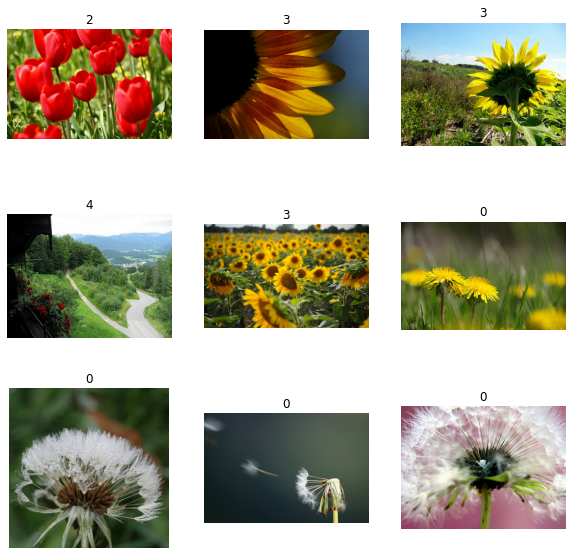

In [5]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
def preprocess_dataset(ds, siimage_sizeze, batch_size):

  ds = ds.map(lambda x, y: (tf.image.resize(x, image_size), y))

  ds = ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

  return ds

train_ds = preprocess_dataset(train_ds, image_size, batch_size) 
validation_ds = preprocess_dataset(validation_ds, image_size, batch_size) 
test_ds = preprocess_dataset(test_ds, image_size, batch_size)

**Model**

In [5]:
def augmentation(x):

  data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal"), 
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)],
        name='data_augmentation')

  return data_augmentation(x)


def make_cnn(image_size):

  inputs = keras.Input(shape=(image_size + (3,)))
  x = augmentation(inputs)
  x = layers.Rescaling(1./255)(x)
  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  outputs = layers.Dense(5)(x)
  model = keras.Model(inputs, outputs, name='cnn_model')

  model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

  return model

In [ ]:
model = make_cnn(image_size)
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 180, 180, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        92

In [ ]:
epochs = 30 
model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 37s 242ms/step - loss: 1.3097 - accuracy: 0.4339 - val_loss: 1.1133 - val_accuracy: 0.5613
Epoch 2/30
92/92 [==============================] - 14s 157ms/step - loss: 1.0387 - accuracy: 0.5841 - val_loss: 1.0626 - val_accuracy: 0.5886
Epoch 3/30
92/92 [==============================] - 14s 157ms/step - loss: 0.9233 - accuracy: 0.6526 - val_loss: 0.9248 - val_accuracy: 0.6512
Epoch 4/30
92/92 [==============================] - 14s 158ms/step - loss: 0.8408 - accuracy: 0.6734 - val_loss: 0.8910 - val_accuracy: 0.6757
Epoch 5/30
92/92 [==============================] - 15s 162ms/step - loss: 0.7875 - accuracy: 0.6958 - val_loss: 0.8255 - val_accuracy: 0.6812
Epoch 6/30
92/92 [==============================] - 14s 157ms/step - loss: 0.7309 - accuracy: 0.7183 - val_loss: 0.8161 - val_accuracy: 0.7003
Epoch 7/30
92/92 [==============================] - 15s 160ms/step - loss: 0.6931 - accuracy: 0.7428 - val_loss: 0.8301 - val_accuracy: 0.6839

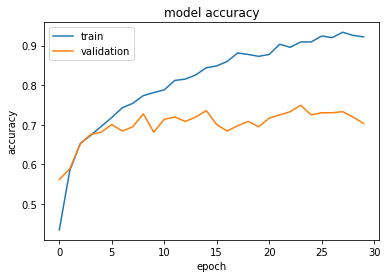

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

**Assignment 1. Customize fit function by overriding `train-step` and `test_step` functions as described in module_5 notebook.** 

In [6]:
class make_cnn_2(tf.keras.Model):


  def __init__(self):
    super().__init__()

    self.data_aug = tf.keras.Sequential(
        [tf.keras.layers.RandomFlip("horizontal"), 
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1)])
    self.scale = tf.keras.layers.Rescaling(1./255)
    self.conv_1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
    self.max_pool_1 = tf.keras.layers.MaxPooling2D()
    self.conv_2 = tf.keras.layers.Conv2D(32, 3, activation='relu')
    self.max_pool_2 = tf.keras.layers.MaxPooling2D()
    self.conv_3 = tf.keras.layers.Conv2D(32, 3, activation='relu')
    self.max_pool_3 = tf.keras.layers.MaxPooling2D()
    self.flatten = tf.keras.layers.Flatten()
    self.dense_1 = tf.keras.layers.Dense(128, activation='relu')
    self.dense_2 = tf.keras.layers.Dense(5)


  def call(self, inputs):

    x = self.data_aug(inputs)
    x = self.scale(x)
    x = self.conv_1(x)
    x = self.max_pool_1(x)
    x = self.conv_2(x)
    x = self.max_pool_2(x) 
    x = self.conv_3(x)
    x = self.max_pool_3(x) 
    x = self.flatten(x)
    x = self.dense_1(x)
    out = self.dense_2(x)

    return out

In [ ]:
input_layer = Input(shape=(image_size + (3,)))
x = make_cnn_2()(input_layer) 
model = Model(inputs=input_layer, outputs=x)
print(model.summary(expand_nested=True))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 make_cnn_2 (make_cnn_2)     (None, 5)                 1658565   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| sequential (Sequential)   (None, 180, 180, 3)       0         |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| random_flip_1 (RandomFlip)  (None, 180, 180, 3)   0         ||
||                                                             ||
|| random_rotation_1 (RandomRo  (None, 180, 180, 3)  0         ||
|| tation)                                                     ||
||                                                             ||
|| random_zoom_1 (RandomZoom)  (None, 180, 180, 3)   0         ||
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

*   Create a new class that subclasses keras.Model.
*   Override the method train_step.
*   Return a dictionary mapping metric names and loss to their current value.

In [ ]:
class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to fit().
        x, y = data

        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = self(x, training=True)  
            # Compute the loss value.
            # The loss function is configured in compile().
            loss = self.compiled_loss(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in compile().
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dict mapping metric names to current value.
        return {m.name: m.result() for m in self.metrics}

In [ ]:
inputs = Input(shape=(image_size + (3,)))
outputs = make_cnn_2()(inputs) 
model = CustomModel(inputs, outputs)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

In [ ]:
epochs = 30 
model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 33s 195ms/step - loss: 1.2465 - accuracy: 0.4670 - val_loss: 1.1255 - val_accuracy: 0.5341
Epoch 2/30
92/92 [==============================] - 13s 145ms/step - loss: 1.0175 - accuracy: 0.6046 - val_loss: 0.9805 - val_accuracy: 0.6376
Epoch 3/30
92/92 [==============================] - 13s 143ms/step - loss: 0.9160 - accuracy: 0.6485 - val_loss: 0.8970 - val_accuracy: 0.6567
Epoch 4/30
92/92 [==============================] - 14s 147ms/step - loss: 0.8453 - accuracy: 0.6778 - val_loss: 0.8412 - val_accuracy: 0.6621
Epoch 5/30
92/92 [==============================] - 13s 146ms/step - loss: 0.7657 - accuracy: 0.7061 - val_loss: 0.8145 - val_accuracy: 0.6866
Epoch 6/30
92/92 [==============================] - 13s 145ms/step - loss: 0.7121 - accuracy: 0.7292 - val_loss: 0.7920 - val_accuracy: 0.6757
Epoch 7/30
92/92 [==============================] - 13s 144ms/step - loss: 0.6740 - accuracy: 0.7422 - val_loss: 0.8226 - val_accuracy: 0.7003

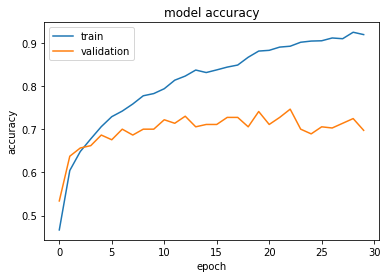

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

**Lower Level:**

We can skip passing loss function or metrics in compile().

In [7]:
class CustomModel(keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = keras.metrics.Mean(name = "loss")
        self.acc_metric = keras.metrics.SparseCategoricalAccuracy(name = "acc")

    def train_step(self, data):

        x, y = data

        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = self(x, training=True) 

            # Compute our own loss
            loss = tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits = True, reduction=tf.keras.losses.Reduction.NONE)(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        self.loss_tracker.update_state(loss) 
        self.acc_metric.update_state(y, y_pred) 
        return {
            "loss": self.loss_tracker.result(), 
            "acc": self.acc_metric.result()
            }

    @property
    def metrics(self):
        # We need to call reset_states() on our metrics between each epoch.
        # Otherwise calling result() would return an average since the start of training.
        # We just list our Metric objects here. 
        # The model will automatically call reset_states() on any object listed here
        # at the beginning of each fit() epoch or at the beginning of a call to evaluate().
        return [self.loss_tracker, self.acc_metric]

    def test_step(self, data):

        x, y = data

        # Compute predictions
        y_pred = self(x, training=False)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits = True, reduction=tf.keras.losses.Reduction.NONE)(y, y_pred)
        
        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.acc_metric.update_state(y, y_pred)

        return {
            "loss": self.loss_tracker.result(), 
            "acc": self.acc_metric.result()
            }

In [9]:
inputs = Input(shape=(image_size + (3,)))
outputs = make_cnn_2()(inputs) 
model = CustomModel(inputs, outputs)
print(model.summary(expand_nested=True))

model.compile(
    optimizer=keras.optimizers.Adam()
)

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 make_cnn_2 (make_cnn_2)     (None, 5)                 1658565   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| sequential (Sequential)   (None, 180, 180, 3)       0         |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| random_flip (RandomFlip)  (None, 180, 180, 3)     0         ||
||                                                             ||
|| random_rotation (RandomRota  (None, 180, 180, 3)  0         ||
|| tion)                                                       ||
||                                                             ||
|| random_zoom (RandomZoom)  (None, 180, 180, 3)     0         ||
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [10]:
epochs = 30 
model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 33s 205ms/step - loss: 1.2823 - acc: 0.4527 - val_loss: 1.1272 - val_acc: 0.5313
Epoch 2/30
92/92 [==============================] - 14s 151ms/step - loss: 1.0460 - acc: 0.5814 - val_loss: 0.9595 - val_acc: 0.6485
Epoch 3/30
92/92 [==============================] - 14s 150ms/step - loss: 0.9305 - acc: 0.6396 - val_loss: 0.8942 - val_acc: 0.6757
Epoch 4/30
92/92 [==============================] - 15s 159ms/step - loss: 0.8525 - acc: 0.6676 - val_loss: 0.8596 - val_acc: 0.6866
Epoch 5/30
92/92 [==============================] - 14s 151ms/step - loss: 0.7957 - acc: 0.7016 - val_loss: 0.8172 - val_acc: 0.6839
Epoch 6/30
92/92 [==============================] - 14s 149ms/step - loss: 0.7308 - acc: 0.7173 - val_loss: 0.7800 - val_acc: 0.6948
Epoch 7/30
92/92 [==============================] - 15s 160ms/step - loss: 0.6841 - acc: 0.7374 - val_loss: 0.8033 - val_acc: 0.7221
Epoch 8/30
92/92 [==============================] - 14s 150ms/step - 

**Assignment 2. Write a custom training loop as described in module_6 notebook.** 

In [ ]:
inputs = Input(shape=(image_size + (3,)))
outputs = make_cnn_2()(inputs) 
model = Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [ ]:
@tf.function
def train_step(x, y):

    with tf.GradientTape() as tape:

        logits = model(x, training=True)

        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

@tf.function
def test_step(x, y):

    val_logits = model(x, training=False)
    
    val_acc_metric.update_state(y, val_logits)

In [ ]:
epochs = 30
steps = 50

for epoch in range(epochs):

    print(f"\nStart of epoch: {epoch}")

    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):

        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 50 batches.
        if step % steps == 0:
          print(f"Training loss (for one batch) at step {step}: {loss_value}")
          print(f"Seen so far: {(step + 1) * (batch_size)} samples")

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print(f"Training acc over epoch: {train_acc}")

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in validation_ds:
      test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()

    print(f"Validation acc: {val_acc}")
    print(f"Time taken: {time.time() - start_time}")


Start of epoch: 0
Training loss (for one batch) at step 0: 1.6174272298812866
Seen so far: 32 samples
Training loss (for one batch) at step 50: 1.2452353239059448
Seen so far: 1632 samples
Training acc over epoch: 0.4243869185447693
Validation acc: 0.5722070932388306
Time taken: 34.03456354141235

Start of epoch: 1
Training loss (for one batch) at step 0: 1.0950732231140137
Seen so far: 32 samples
Training loss (for one batch) at step 50: 1.090437650680542
Seen so far: 1632 samples
Training acc over epoch: 0.5834468603134155
Validation acc: 0.6130790114402771
Time taken: 11.371697187423706

Start of epoch: 2
Training loss (for one batch) at step 0: 1.0146212577819824
Seen so far: 32 samples
Training loss (for one batch) at step 50: 0.9877734780311584
Seen so far: 1632 samples
Training acc over epoch: 0.6413487792015076
Validation acc: 0.6457765698432922
Time taken: 11.653565883636475

Start of epoch: 3
Training loss (for one batch) at step 0: 1.050774097442627
Seen so far: 32 samples


**Assignment 3. Apply transfer learning (20 pochs) and fine-tuning (10 epochs) startegies as described in module_7 notebook.**

In [ ]:
def augmentation(x):

  data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal"), 
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)],
        name='data_augmentation')

  return data_augmentation(x)

def build_model(image_shape):

    base_model = keras.applications.Xception(
      weights="imagenet",  
      input_shape=(image_shape + (3,)),
      include_top=False,
    )  

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(image_shape + (3,)), name='inputs')

    # Apply random data augmentation
    x = augmentation(inputs)  

    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    x = layers.Rescaling(scale=1 / 127.5, offset=-1, name='rescaling')(x)

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)

    x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)

    x = layers.Dropout(0.2, name='dropout')(x) 

    #outputs = layers.Dense(5, activation='softmax', name='outputs')(x)
    #from_logits=True tells the loss function that an activation function (e.g. softmax) was not applied on the last layer, 
    #in which case your output needs to be as the number of classes. This is equivalent to using a softmax and from_logits=False. 
    outputs = layers.Dense(5, name='outputs')(x)

    model = keras.Model(inputs, outputs)

    model.compile(
      optimizer=keras.optimizers.Adam(),
      #loss=keras.losses.BinaryCrossentropy(from_logits=True),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      #metrics=[keras.metrics.BinaryAccuracy(name='accuracy')],
      metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
    )

    return base_model, model

In [ ]:
base_model, model = build_model(image_size)

model.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 180, 180, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 180, 180, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                              

In [ ]:
epochs = 20 

model.fit(
    train_ds, 
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 42s 303ms/step - loss: 0.8351 - accuracy: 0.6914 - val_loss: 0.5240 - val_accuracy: 0.8202
Epoch 2/20
92/92 [==============================] - 25s 274ms/step - loss: 0.5088 - accuracy: 0.8208 - val_loss: 0.4441 - val_accuracy: 0.8283
Epoch 3/20
92/92 [==============================] - 20s 213ms/step - loss: 0.4540 - accuracy: 0.8403 - val_loss: 0.4029 - val_accuracy: 0.8420
Epoch 4/20
92/92 [==============================] - 22s 243ms/step - loss: 0.4039 - accuracy: 0.8593 - val_loss: 0.3856 - val_accuracy: 0.8529
Epoch 5/20
92/92 [==============================] - 20s 221ms/step - loss: 0.3763 - accuracy: 0.8730 - val_loss: 0.3699 - val_accuracy: 0.8638
Epoch 6/20
92/92 [==============================] - 20s 213ms/step - loss: 0.3591 - accuracy: 0.8736 - val_loss: 0.3610 - val_accuracy: 0.8665
Epoch 7/20
92/92 [==============================] - 20s 221ms/step - loss: 0.3376 - accuracy: 0.8822 - val_loss: 0.3538 - val_accuracy: 0.8719

In [ ]:
def unfreeze(base_model, model):

    # Note that it keeps running in inference mode
    # since we passed `training=False` when calling it. This means that
    # the batchnorm layers will not update their batch statistics.
    # This prevents the batchnorm layers from undoing all the training
    # we have done so far.
    base_model.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5), 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    return model

In [ ]:
unfrozen_model = unfreeze(base_model, model)
unfrozen_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 180, 180, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 180, 180, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [ ]:
epochs = 10

unfrozen_model.fit(
    train_ds, 
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 79s 485ms/step - loss: 0.2038 - sparse_categorical_accuracy: 0.9264 - val_loss: 0.3182 - val_sparse_categorical_accuracy: 0.8883
Epoch 2/10
92/92 [==============================] - 42s 456ms/step - loss: 0.1591 - sparse_categorical_accuracy: 0.9414 - val_loss: 0.3128 - val_sparse_categorical_accuracy: 0.8910
Epoch 3/10
92/92 [==============================] - 42s 453ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.3042 - val_sparse_categorical_accuracy: 0.8910
Epoch 4/10
92/92 [==============================] - 42s 457ms/step - loss: 0.0923 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.2959 - val_sparse_categorical_accuracy: 0.9046
Epoch 5/10
92/92 [==============================] - 42s 457ms/step - loss: 0.0785 - sparse_categorical_accuracy: 0.9731 - val_loss: 0.2945 - val_sparse_categorical_accuracy: 0.9101
Epoch 6/10
92/92 [==============================] - 41s 450ms/step - loss: 0.0571 - sparse_cate